# Projet 6 : Classez des images à l'aide d'algorithmes de Deep Learning

L'objectif de ce projet est de faire de la classification d'images de chien de la base de données Stanford Dogs Dataset. On va construire un réseau de neurones convolutif (CNN) pour reconnaître la race d'un chien à partir d'une image.

## Notebook 1 : Deep Learning
* Extraction des images
* Visualisation des images
* Data Augmentation
* Split des données


Ressources utiles : 

Data Augmentation : https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844

batch size : https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/

split : https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

tensorflow-gpu install : https://medium.com/analytics-vidhya/solution-to-tensorflow-2-not-using-gpu-119fb3e04daa

## Librairies utilisées

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

On utilise dans cette étude tensorflow-gpu pour bénéficier de la puissance de calcul de la carte graphique. L'installation de tensorflow-gpu a posé beaucoup de problèmes. La version actuelle a été installée en faisant :
* conda create -n projet6 python==3.8
* conda activate projet6
* conda install cudatoolkit=11.0 cudnn=8.0 -c=conda-forge
* pip install --upgrade tensorflow-gpu==2.4.1

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Extraction des images

Les images ont été extraites à l'adresse suivante : http://vision.stanford.edu/aditya86/ImageNetDogs/

Elles sont stockées dans un dossier datasets/

In [4]:
# download data from Stanfords Dogs Dataset
data_dir = tf.keras.utils.get_file(
    fname='images.tar',
    origin='http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar',
    cache_subdir='datasets',
    extract=False,
    cache_dir='./')


On change le nom des dossiers pour avoir le nom des classes

In [5]:
basedir = os.path.abspath('./datasets/Images')
for name_dir in os.listdir(basedir):
  if not os.path.isdir(os.path.join(basedir, name_dir)): # Not a directory
    continue 
  if 'n02' in name_dir: # Invalid format
    new_name = name_dir.split(sep='-', maxsplit=1)[1]
    os.rename(
        os.path.join(basedir, name_dir),
        os.path.join(basedir, new_name))
  

## Visualisation des images

On charge notre dataset dans un objet tf.data.Dataset

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='./datasets/Images',
    labels='inferred')

Found 20580 files belonging to 120 classes.


In [7]:
num_classes = len(dataset.class_names)
print(f'Il y a {num_classes} classes de race de chien dans notre dataset')

Il y a 120 classes de race de chien dans notre dataset


On compte le nombre de fichier dans chaque dossier.

In [8]:
list_classes = []
list_size = []

basedir = os.path.abspath('./datasets/Images')
for name_class in os.listdir(basedir):
    class_path = os.path.join(basedir, name_class)
    list_classes.append(name_class)
    list_size.append(len(os.listdir(class_path)))

df = pd.DataFrame({'classes':list_classes, 'size':list_size})

On visualise le nombre d'images par races de chien.

<AxesSubplot:xlabel='size', ylabel='classes'>

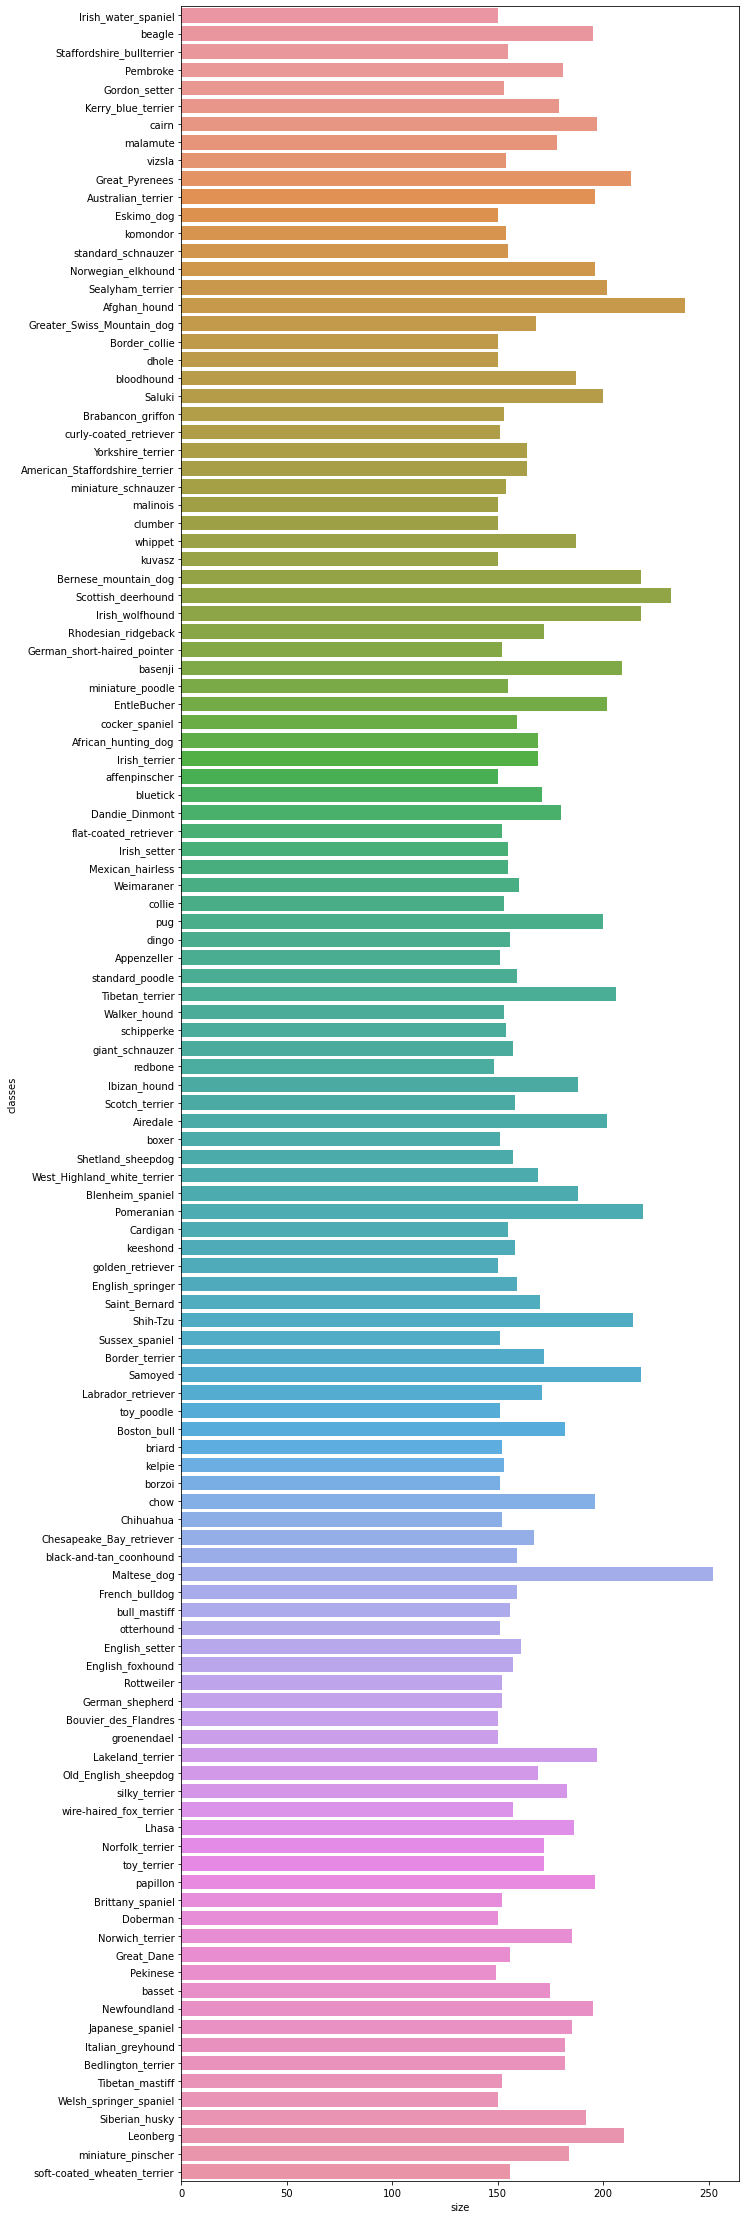

In [9]:
plt.figure(figsize=(10,40))
sns.barplot(x='size', y='classes', data=df)

Quelques images d'exemple du dataset. La méthode take d'un objet tf.data.Dataset permet d'extraire un objet tf.data.Dataset qui correspond à un batch d'images.

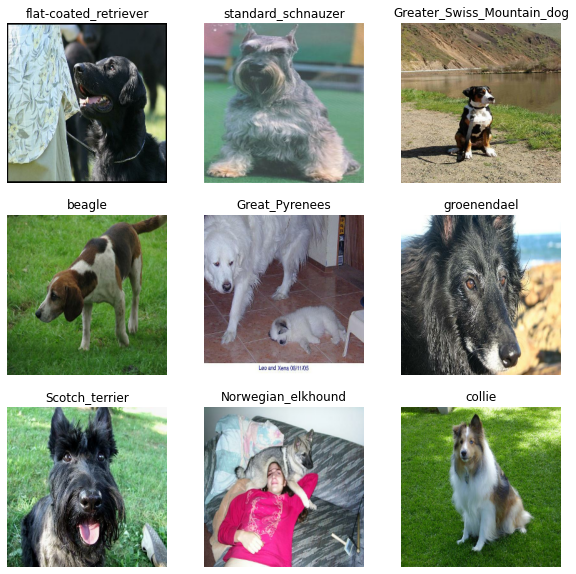

In [10]:
class_names = dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Data Augmentation

En Deep Learning on a besoin d'un très grand nombre de données. Il existe des techniques de Data Augmentation qui permettent d'améliorer un modèle lorsque l'on a peu de données. Cela consiste à générer des modifications aléatoires dans les images pour faire comme si on avait plus d'images. Donc on ne modifie pas le nombre d'images mais on essaie d'exploiter le plus possible les images. 

Pour cela on peut utiliser la classe ImageDataGenerator de tensorflow : https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

Text(0.5, 1.0, 'Maltese_dog')

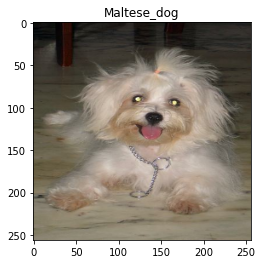

In [11]:
example, = dataset.unbatch().take(1)
image, label = example
image = image.numpy().astype("uint8")


plt.imshow(image)
plt.title(class_names[label])

In [12]:
images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

On va appliquer des modifications à cette image. On définit une fonction qui prend en entrée l'image à modifier et un object ImageDataGenerator qui permet de réaliser une modification.

In [13]:
def plot(images, data_generator):
    """
    Plots 4 images generated by an object of the ImageDataGenerator class.
    """
    data_generator.fit(images)
    image_iterator = data_generator.flow(images)
    
    # Plot the images given by the iterator
    fig, rows = plt.subplots(nrows=1, ncols=4, figsize=(18,18))
    for row in rows:
        row.imshow(image_iterator.next()[0].astype('int'))
        row.axis('off')
    plt.show()


Il existe plusieurs techniques pour créer de nouvelles images.

### Rotation

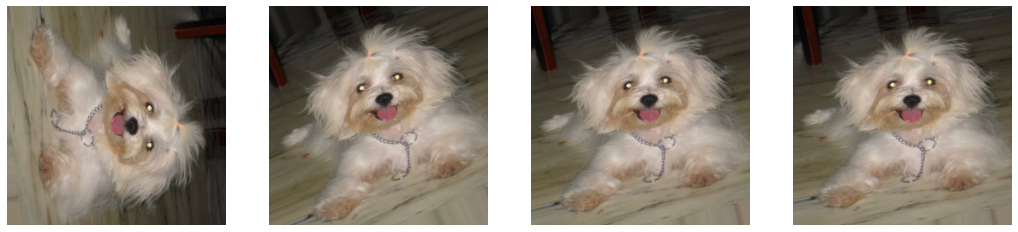

In [14]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=90)
plot(images, data_generator)

### Déplacement horizontal

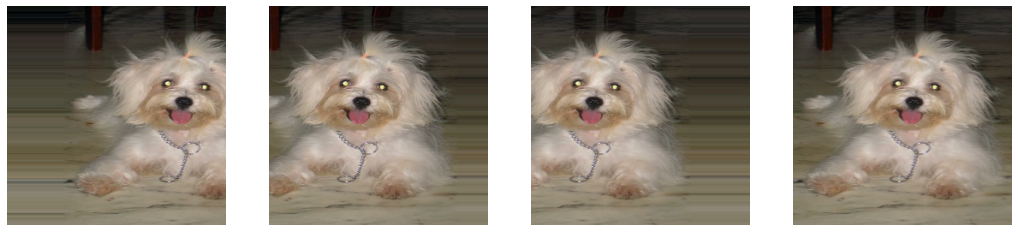

In [15]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.3)
plot(images, data_generator)

### Déplacement vertical

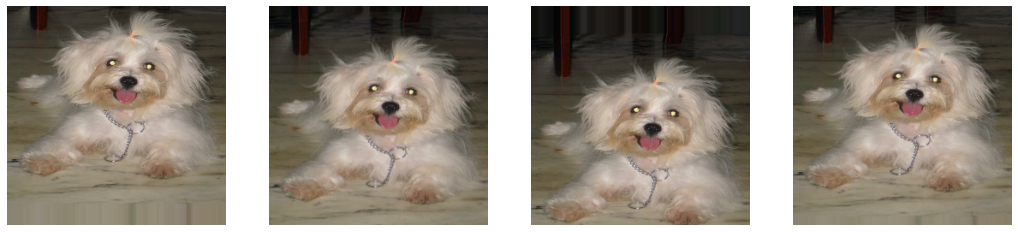

In [16]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(height_shift_range=0.3)
plot(images, data_generator)

### Luminosité

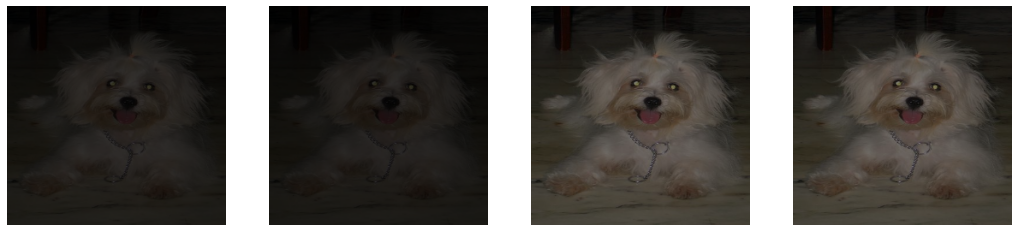

In [17]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(brightness_range=(0.1, 0.9))
plot(images, data_generator)

### Etirement

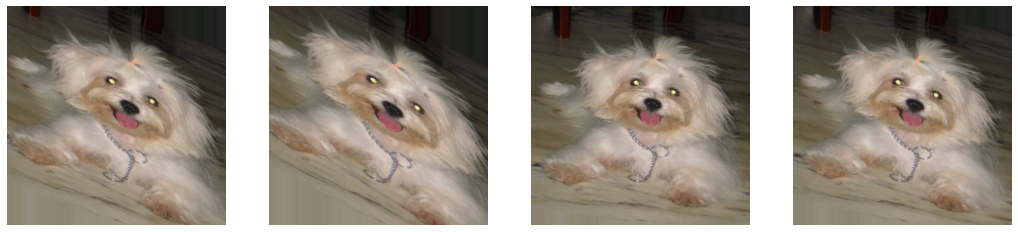

In [18]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=45.0)
plot(images, data_generator)

### Zoom

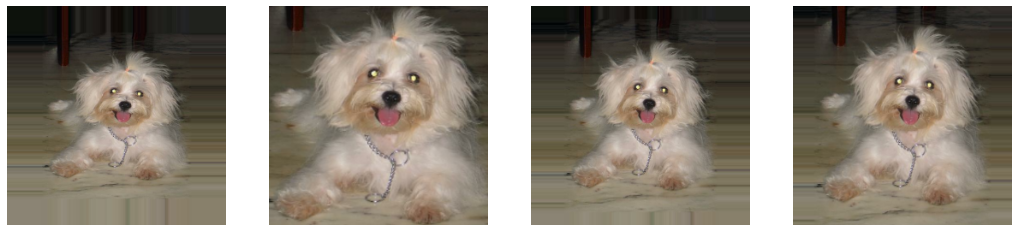

In [19]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=[0.5, 1.5])
plot(images, data_generator)

### Channel shift

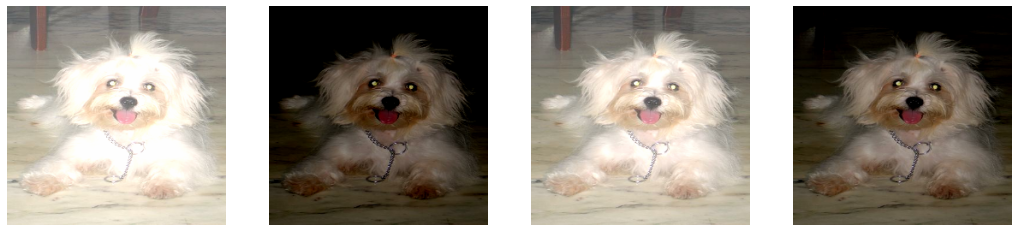

In [20]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(channel_shift_range=150.0)
plot(images, data_generator)

### Inversement horizontal

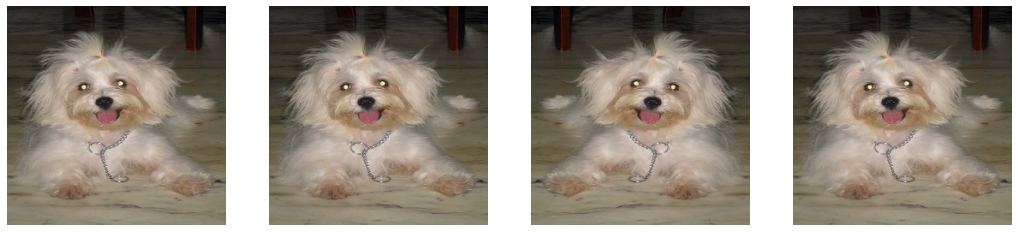

In [21]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True)
plot(images, data_generator)

### Inversement vertical

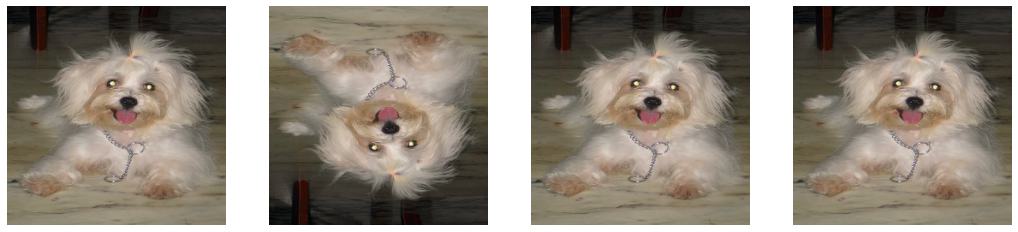

In [22]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(vertical_flip=True)
plot(images, data_generator)

## Split des données

In [23]:
batch_size = 32
img_height = 160
img_width = 160
img_shape = (img_height, img_width)
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)

### sans Data Augmentation

In [24]:
no_augmentation_kwargs = dict(
    rescale=1./255,
    validation_split=0.2)

In [25]:
train_datagen_no_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**no_augmentation_kwargs)

train_generator_no_augmentation = train_datagen_no_augmentation.flow_from_directory(
    directory='./datasets/Images',
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)

Found 16508 images belonging to 120 classes.


In [26]:
validation_datagen_no_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**no_augmentation_kwargs)

validation_generator_no_augmentation = validation_datagen_no_augmentation.flow_from_directory(
    directory='./datasets/Images',
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True)

Found 4072 images belonging to 120 classes.


### avec Data Augmentation

In [27]:
augmentation_kwargs = dict(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=(0.1, 0.9),
    shear_range=45.0,
    zoom_range=[0.5, 1.5],
    channel_shift_range=150.0,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2)

In [28]:
train_datagen_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**augmentation_kwargs)

train_generator_augmentation = train_datagen_augmentation.flow_from_directory(
    directory='./datasets/Images',
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)

Found 16508 images belonging to 120 classes.


In [29]:
validation_datagen_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**no_augmentation_kwargs)

validation_generator_augmentation = validation_datagen_augmentation.flow_from_directory(
    directory='./datasets/Images',
    target_size=img_shape,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True)

Found 4072 images belonging to 120 classes.


## Model de base

### sans Data Augmentation

In [30]:
model_base = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(train_generator_no_augmentation.num_classes, activation='softmax')
])

In [31]:
model_base.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

In [32]:
steps_per_epoch = train_generator_no_augmentation.samples // train_generator_no_augmentation.batch_size
validation_steps = validation_generator_no_augmentation.samples // validation_generator_no_augmentation.batch_size

history_base = model_base.fit(
    train_generator_no_augmentation,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator_no_augmentation,
    validation_steps=validation_steps)

Epoch 1/10
515/515 [==============================] - 60s 98ms/step - loss: 4.7837 - accuracy: 0.0101 - val_loss: 4.6562 - val_accuracy: 0.0224
Epoch 2/10
515/515 [==============================] - 41s 80ms/step - loss: 4.5462 - accuracy: 0.0298 - val_loss: 4.3531 - val_accuracy: 0.0475
Epoch 3/10
515/515 [==============================] - 41s 79ms/step - loss: 4.1775 - accuracy: 0.0723 - val_loss: 4.2181 - val_accuracy: 0.0610
Epoch 4/10
515/515 [==============================] - 41s 80ms/step - loss: 3.7760 - accuracy: 0.1336 - val_loss: 4.2339 - val_accuracy: 0.0780
Epoch 5/10
515/515 [==============================] - 41s 80ms/step - loss: 3.2361 - accuracy: 0.2335 - val_loss: 4.5358 - val_accuracy: 0.0694
Epoch 6/10
515/515 [==============================] - 41s 79ms/step - loss: 2.5487 - accuracy: 0.3677 - val_loss: 4.9981 - val_accuracy: 0.0743
Epoch 7/10
515/515 [==============================] - 41s 80ms/step - loss: 1.8937 - accuracy: 0.5155 - val_loss: 5.9851 - val_accuracy:

#### Learning curves

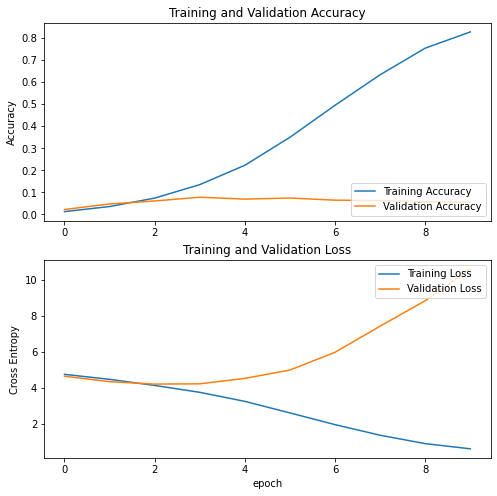

In [33]:
acc = history_base.history['accuracy']
val_acc = history_base.history['val_accuracy']

loss = history_base.history['loss']
val_loss = history_base.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### avec Data Augmentation

In [34]:
model_base = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(train_generator_augmentation.num_classes, activation='softmax')
])

In [35]:
model_base.compile(
  optimizer='adam',
  loss=tf.losses.CategoricalCrossentropy(),
  metrics=['accuracy'])

In [36]:
steps_per_epoch = train_generator_augmentation.samples // train_generator_augmentation.batch_size
validation_steps = validation_generator_augmentation.samples // validation_generator_augmentation.batch_size

history_base = model_base.fit(
    train_generator_augmentation,
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator_augmentation,
    validation_steps=validation_steps)

Epoch 1/10
515/515 [==============================] - 113s 219ms/step - loss: 4.7884 - accuracy: 0.0090 - val_loss: 4.7819 - val_accuracy: 0.0130
Epoch 2/10
515/515 [==============================] - 113s 219ms/step - loss: 4.7818 - accuracy: 0.0125 - val_loss: 4.7797 - val_accuracy: 0.0123
Epoch 3/10
515/515 [==============================] - 113s 219ms/step - loss: 4.7795 - accuracy: 0.0116 - val_loss: 4.7564 - val_accuracy: 0.0113
Epoch 4/10
515/515 [==============================] - 112s 218ms/step - loss: 4.7479 - accuracy: 0.0183 - val_loss: 4.7150 - val_accuracy: 0.0177
Epoch 5/10
515/515 [==============================] - 112s 218ms/step - loss: 4.7031 - accuracy: 0.0173 - val_loss: 4.6891 - val_accuracy: 0.0162
Epoch 6/10
515/515 [==============================] - 112s 218ms/step - loss: 4.6920 - accuracy: 0.0163 - val_loss: 4.6836 - val_accuracy: 0.0199
Epoch 7/10
515/515 [==============================] - 112s 218ms/step - loss: 4.6815 - accuracy: 0.0163 - val_loss: 4.6752 -

#### Learning curves

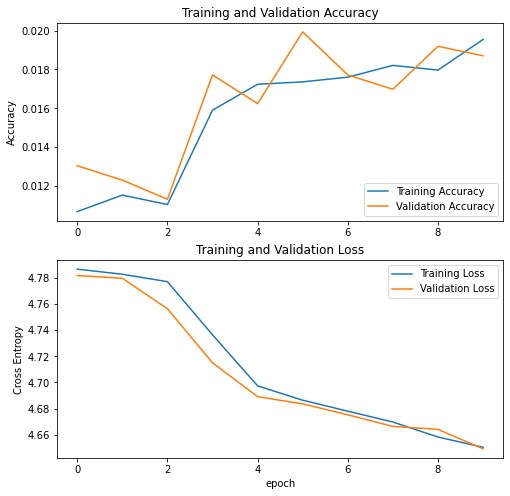

In [37]:
acc = history_base.history['accuracy']
val_acc = history_base.history['val_accuracy']

loss = history_base.history['loss']
val_loss = history_base.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Transfer learning : Features extraction

In [83]:
IMG_SIZE = (160, 160)
IMG_SHAPE = IMG_SIZE + (3,)
base_learning_rate = 0.001
initial_epochs = 10
batch_size = 32

### ResNet50V2

In [84]:
augmentation_kwargs = dict(
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=(0.1, 0.9),
    shear_range=45.0,
    zoom_range=[0.5, 1.5],
    channel_shift_range=150.0,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
    validation_split=0.2)

In [85]:
no_augmentation_kwargs = dict(
    preprocessing_function=tf.keras.applications.resnet_v2.preprocess_input,
    validation_split=0.2)

In [86]:
train_datagen_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**augmentation_kwargs)

train_generator_augmentation = train_datagen_augmentation.flow_from_directory(
    directory='./datasets/Images',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)

Found 16508 images belonging to 120 classes.


In [87]:
validation_datagen_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**no_augmentation_kwargs)

validation_generator_augmentation = validation_datagen_augmentation.flow_from_directory(
    directory='./datasets/Images',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True)

Found 4072 images belonging to 120 classes.


In [90]:
base_ResNet50V2 = tf.keras.applications.ResNet50V2(include_top=False,
                                 weights='imagenet',
                                 input_tensor=None,
                                 input_shape=IMG_SHAPE,
                                 pooling=None,
                                 classes=1000)


In [91]:
image_batch, label_batch = next(iter(train_generator_augmentation))
feature_batch = base_ResNet50V2(image_batch)
print(feature_batch.shape)

(32, 5, 5, 2048)


In [92]:
base_ResNet50V2.trainable = False

In [93]:
base_ResNet50V2.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 166, 166, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 80, 80, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 82, 82, 64)   0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [94]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [95]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 120)


In [96]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_ResNet50V2(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model_ResNet50V2 = tf.keras.Model(inputs, outputs)

In [97]:
model_ResNet50V2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [98]:
model_ResNet50V2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 5, 5, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               245880    
Total params: 23,810,680
Trainable params: 245,880
Non-trainable params: 23,564,800
_________________________________________________________________


In [99]:
len(model_ResNet50V2.trainable_variables)

2

In [100]:
loss0, accuracy0 = model_ResNet50V2.evaluate(validation_generator_augmentation)

128/128 [==============================] - 9s 65ms/step - loss: 6.8469 - accuracy: 0.0041


In [101]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 6.89
initial accuracy: 0.01


In [102]:
steps_per_epoch = train_generator_augmentation.samples // train_generator_augmentation.batch_size
validation_steps = validation_generator_augmentation.samples // validation_generator_augmentation.batch_size

history_ResNet50V2 = model_ResNet50V2.fit(
    train_generator_augmentation,
    epochs=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator_augmentation,
    validation_steps=validation_steps)

Epoch 1/10
515/515 [==============================] - 101s 193ms/step - loss: 5.0541 - accuracy: 0.0702 - val_loss: 2.5711 - val_accuracy: 0.3848
Epoch 2/10
515/515 [==============================] - 99s 192ms/step - loss: 4.5994 - accuracy: 0.1097 - val_loss: 2.4004 - val_accuracy: 0.4245
Epoch 3/10
515/515 [==============================] - 100s 195ms/step - loss: 4.4998 - accuracy: 0.1234 - val_loss: 2.4077 - val_accuracy: 0.4405
Epoch 4/10
515/515 [==============================] - 102s 199ms/step - loss: 4.4352 - accuracy: 0.1304 - val_loss: 2.3193 - val_accuracy: 0.4456
Epoch 5/10
515/515 [==============================] - 102s 198ms/step - loss: 4.3898 - accuracy: 0.1349 - val_loss: 2.2791 - val_accuracy: 0.4688
Epoch 6/10
515/515 [==============================] - 103s 200ms/step - loss: 4.3984 - accuracy: 0.1349 - val_loss: 2.3412 - val_accuracy: 0.4656
Epoch 7/10
515/515 [==============================] - 103s 199ms/step - loss: 4.3565 - accuracy: 0.1386 - val_loss: 2.3929 - 

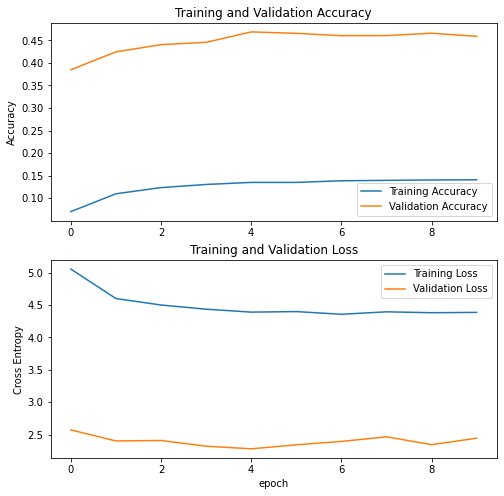

In [103]:
acc = history_ResNet50V2.history['accuracy']
val_acc = history_ResNet50V2.history['val_accuracy']

loss = history_ResNet50V2.history['loss']
val_loss = history_ResNet50V2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### MobileNetV2

In [104]:
augmentation_kwargs = dict(
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=(0.1, 0.9),
    shear_range=45.0,
    zoom_range=[0.5, 1.5],
    channel_shift_range=150.0,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2)

In [105]:
no_augmentation_kwargs = dict(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2)

In [106]:
train_datagen_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**augmentation_kwargs)

train_generator_augmentation = train_datagen_augmentation.flow_from_directory(
    directory='./datasets/Images',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)

Found 16508 images belonging to 120 classes.


In [107]:
validation_datagen_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**no_augmentation_kwargs)

validation_generator_augmentation = validation_datagen_augmentation.flow_from_directory(
    directory='./datasets/Images',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True)

Found 4072 images belonging to 120 classes.


In [108]:
base_MobileNetV2 = tf.keras.applications.MobileNetV2(include_top=False,
                                 weights='imagenet',
                                 input_tensor=None,
                                 input_shape=IMG_SHAPE,
                                 pooling=None,
                                 classes=1000)


In [109]:
image_batch, label_batch = next(iter(train_generator_augmentation))
feature_batch = base_MobileNetV2(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [110]:
base_MobileNetV2.trainable = False

In [111]:
base_MobileNetV2.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_11[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [112]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [113]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 120)


In [114]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_MobileNetV2(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model_MobileNetV2 = tf.keras.Model(inputs, outputs)

In [115]:
model_MobileNetV2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [116]:
model_MobileNetV2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               153720    
Total params: 2,411,704
Trainable params: 153,720
Non-trainable params: 2,257,984
_________________________________________________________________


In [117]:
len(model_MobileNetV2.trainable_variables)

2

In [118]:
loss0, accuracy0 = model_MobileNetV2.evaluate(validation_generator_augmentation)

128/128 [==============================] - 9s 65ms/step - loss: 5.2181 - accuracy: 0.0080


In [119]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 5.23
initial accuracy: 0.01


In [120]:
steps_per_epoch = train_generator_augmentation.samples // train_generator_augmentation.batch_size
validation_steps = validation_generator_augmentation.samples // validation_generator_augmentation.batch_size

history_MobileNetV2 = model_MobileNetV2.fit(
    train_generator_augmentation,
    epochs=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator_augmentation,
    validation_steps=validation_steps)

Epoch 1/10
515/515 [==============================] - 101s 193ms/step - loss: 4.5258 - accuracy: 0.0763 - val_loss: 2.1118 - val_accuracy: 0.4712
Epoch 2/10
515/515 [==============================] - 99s 192ms/step - loss: 4.0027 - accuracy: 0.1326 - val_loss: 1.6661 - val_accuracy: 0.5736
Epoch 3/10
515/515 [==============================] - 99s 192ms/step - loss: 3.9080 - accuracy: 0.1528 - val_loss: 1.5163 - val_accuracy: 0.5987
Epoch 4/10
515/515 [==============================] - 99s 193ms/step - loss: 3.8564 - accuracy: 0.1631 - val_loss: 1.4228 - val_accuracy: 0.6105
Epoch 5/10
515/515 [==============================] - 99s 192ms/step - loss: 3.8125 - accuracy: 0.1656 - val_loss: 1.3981 - val_accuracy: 0.6228
Epoch 6/10
515/515 [==============================] - 99s 193ms/step - loss: 3.8148 - accuracy: 0.1689 - val_loss: 1.3444 - val_accuracy: 0.6270
Epoch 7/10
515/515 [==============================] - 100s 193ms/step - loss: 3.7776 - accuracy: 0.1781 - val_loss: 1.3180 - val_

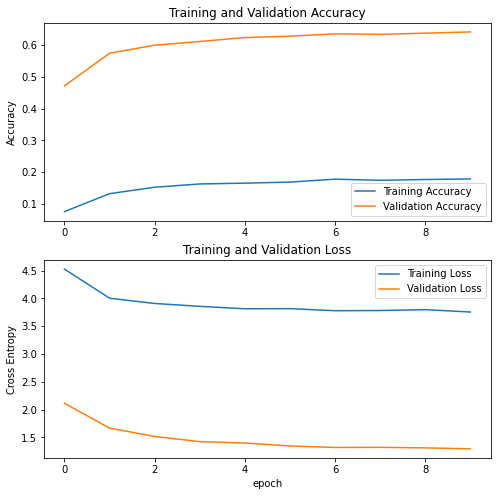

In [121]:
acc = history_MobileNetV2.history['accuracy']
val_acc = history_MobileNetV2.history['val_accuracy']

loss = history_MobileNetV2.history['loss']
val_loss = history_MobileNetV2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### VGG16

In [122]:
augmentation_kwargs = dict(
    rotation_range=90,
    width_shift_range=0.3,
    height_shift_range=0.3,
    brightness_range=(0.1, 0.9),
    shear_range=45.0,
    zoom_range=[0.5, 1.5],
    channel_shift_range=150.0,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2)

In [123]:
no_augmentation_kwargs = dict(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    validation_split=0.2)

In [124]:
train_datagen_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**augmentation_kwargs)

train_generator_augmentation = train_datagen_augmentation.flow_from_directory(
    directory='./datasets/Images',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)

Found 16508 images belonging to 120 classes.


In [125]:
validation_datagen_augmentation = tf.keras.preprocessing.image.ImageDataGenerator(**no_augmentation_kwargs)

validation_generator_augmentation = validation_datagen_augmentation.flow_from_directory(
    directory='./datasets/Images',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True)

Found 4072 images belonging to 120 classes.


In [128]:
base_VGG16 = tf.keras.applications.VGG16(include_top=False,
                                 weights='imagenet',
                                 input_tensor=None,
                                 input_shape=IMG_SHAPE,
                                 pooling=None,
                                 classes=1000)


58892288/58889256 [==============================] - 47s 1us/step


In [129]:
image_batch, label_batch = next(iter(train_generator_augmentation))
feature_batch = base_VGG16(image_batch)
print(feature_batch.shape)

(32, 5, 5, 512)


In [130]:
base_VGG16.trainable = False

In [131]:
base_VGG16.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [132]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [133]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 120)


In [134]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_VGG16(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model_VGG16 = tf.keras.Model(inputs, outputs)

In [135]:
model_VGG16.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [136]:
model_VGG16.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 160, 160, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 120)               61560     
Total params: 14,776,248
Trainable params: 61,560
Non-trainable params: 14,714,688
_________________________________________________________________


In [137]:
len(model_VGG16.trainable_variables)

2

In [138]:
loss0, accuracy0 = model_VGG16.evaluate(validation_generator_augmentation)

128/128 [==============================] - 36s 170ms/step - loss: 30.9418 - accuracy: 0.0131


In [139]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 30.47
initial accuracy: 0.01


In [140]:
steps_per_epoch = train_generator_augmentation.samples // train_generator_augmentation.batch_size
validation_steps = validation_generator_augmentation.samples // validation_generator_augmentation.batch_size

history_VGG16 = model_VGG16.fit(
    train_generator_augmentation,
    epochs=initial_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator_augmentation,
    validation_steps=validation_steps)

Epoch 1/10
515/515 [==============================] - 115s 223ms/step - loss: 9.4194 - accuracy: 0.0293 - val_loss: 8.7977 - val_accuracy: 0.2055
Epoch 2/10
515/515 [==============================] - 101s 196ms/step - loss: 6.6390 - accuracy: 0.0704 - val_loss: 6.1722 - val_accuracy: 0.3120
Epoch 3/10
515/515 [==============================] - 101s 196ms/step - loss: 5.7855 - accuracy: 0.0861 - val_loss: 5.1182 - val_accuracy: 0.3720
Epoch 4/10
515/515 [==============================] - 101s 196ms/step - loss: 5.2841 - accuracy: 0.1023 - val_loss: 4.5606 - val_accuracy: 0.4117
Epoch 5/10
515/515 [==============================] - 101s 197ms/step - loss: 5.0255 - accuracy: 0.1130 - val_loss: 4.2757 - val_accuracy: 0.4208
Epoch 6/10
515/515 [==============================] - 101s 196ms/step - loss: 4.8803 - accuracy: 0.1168 - val_loss: 4.0992 - val_accuracy: 0.4230
Epoch 7/10
515/515 [==============================] - 101s 196ms/step - loss: 4.7427 - accuracy: 0.1218 - val_loss: 4.0687 -

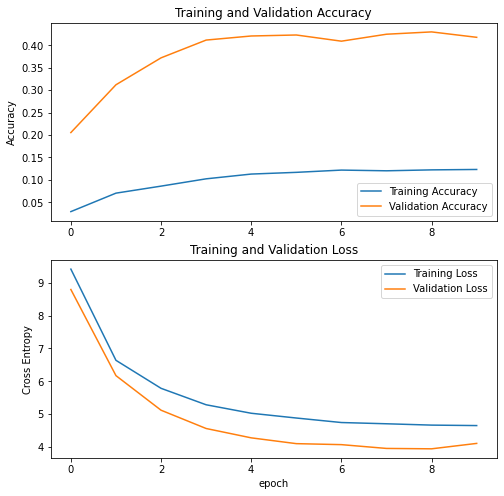

In [141]:
acc = history_VGG16.history['accuracy']
val_acc = history_VGG16.history['val_accuracy']

loss = history_VGG16.history['loss']
val_loss = history_VGG16.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Comparaison

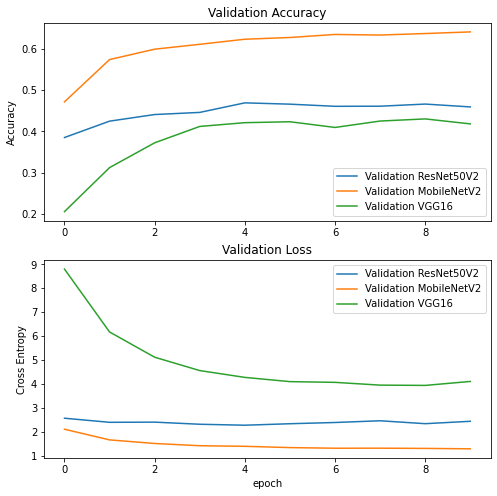

In [142]:
val_acc_ResNet50V2 = history_ResNet50V2.history['val_accuracy']
val_acc_MobileNetV2 = history_MobileNetV2.history['val_accuracy']
val_acc_VGG16 = history_VGG16.history['val_accuracy']


val_loss_ResNet50V2 = history_ResNet50V2.history['val_loss']
val_loss_MobileNetV2 = history_MobileNetV2.history['val_loss']
val_loss_VGG16 = history_VGG16.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(val_acc_ResNet50V2, label='Validation ResNet50V2')
plt.plot(val_acc_MobileNetV2, label='Validation MobileNetV2')
plt.plot(val_acc_VGG16, label='Validation VGG16')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(val_loss_ResNet50V2, label='Validation ResNet50V2')
plt.plot(val_loss_MobileNetV2, label='Validation MobileNetV2')
plt.plot(val_loss_VGG16, label='Validation VGG16')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Validation Loss')
plt.xlabel('epoch')
plt.show()

### Améliorations à venir

regarder les courbes et si overfit alors explorer regularisation norm l2 et dropout.

optimiser nombre de couche, nombre de neurone, pourcentage dropout, et norme regalurization et learning rate

early stopping callback qui permet d'arreter entrainement. 
15 ou 20 epochs